We can use a kd tree to find the edges of a curve (some N-dimensional surface in general). 

This problem is very difficult, because checking if a point is inside the closed surface is hard. So I will apply it to a simpler problem:  find the edges of a function that lies in the [0,1] cube.

To do this, I draw random points, say ${\bf x}^{(i)}=(x_1^{(i)},x_2^{(i)},x_3^{(i)},\dots,y^{(i)})$ and check if there are at least two points with $y^{(1)}$ above (below) $f(x_1^{(1)},x_2^{(1)},x_3^{(1)},\dots)$ and $y^{(2)}$ below (above) $f(x_1^{(2)},x_2^{(2)},x_3^{(2)},\dots)$. If there are such points, then subdivide the cude.


In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
class Cube:
    def __init__(self,center,distance):
        self.center=center
        self.distance=distance
        self.dim=len(center)

        self.generate_signs()#this list will hep us move a point towards backwards and forward directions in all axes 

    def generate_signs(self):
        '''
        The code below generates a list of signs that will move a point to all posible directions.
        Example for 2 dimensions this will give us
        
        [
            [1,1],
            [1,-1],
            [-1,1],
            [-1,-1]
        ]
        
        In three dimensions  
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, 1],
            [1, -1, -1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, 1],
            [-1, -1, -1]
        ]
        
        I came up with this code by trying different things and simplifying the result.
        
        What you need to do to replicate it is to draw on a board what you wat to do:
        take all possible combinations od size=self.dim of a list of +1 and -1 (there are dim**2 combinations).
        What you need to do is understand how to do this:
        
        + +
        + -
        - +
        - -
        
        Then this
        + + +
        + + -
        + - +
        + - -
        - + +
        - + -
        - - +
        - - -
        
        Then the pattern emerges: the last one changes every 1 step the second to last every 2, third to last every 4. 
        Translate this into a for-loop, and you have your result :)
        '''
        self.signs=[[0 for __ in range(self.dim)] for _ in range(2**self.dim)]
        for j in range(self.dim):
            count=0
            for i in range(2**self.dim):
                self.signs[i][j]=(-1)**count
                if (i+1)%(2**(self.dim-1-j))==0:
                    count+=1
                    if count==2:
                        count=0 

    def check_point(self,point):
        '''check whether point is inside this square'''
        for i in range(self.dim):
            if point[i]>self.center[i]+self.distance or point[i]<self.center[i]-self.distance:
                return False
        
        return True
    
    def random_point(self):
        '''generate a random point in this cube'''
        point=[]
        for d in range(self.dim):
            _M=self.center[d]+self.distance
            _m=self.center[d]-self.distance
            point.append(np.random.rand()*(_M-_m)+_m)
            
        return point

<IPython.core.display.Javascript object>


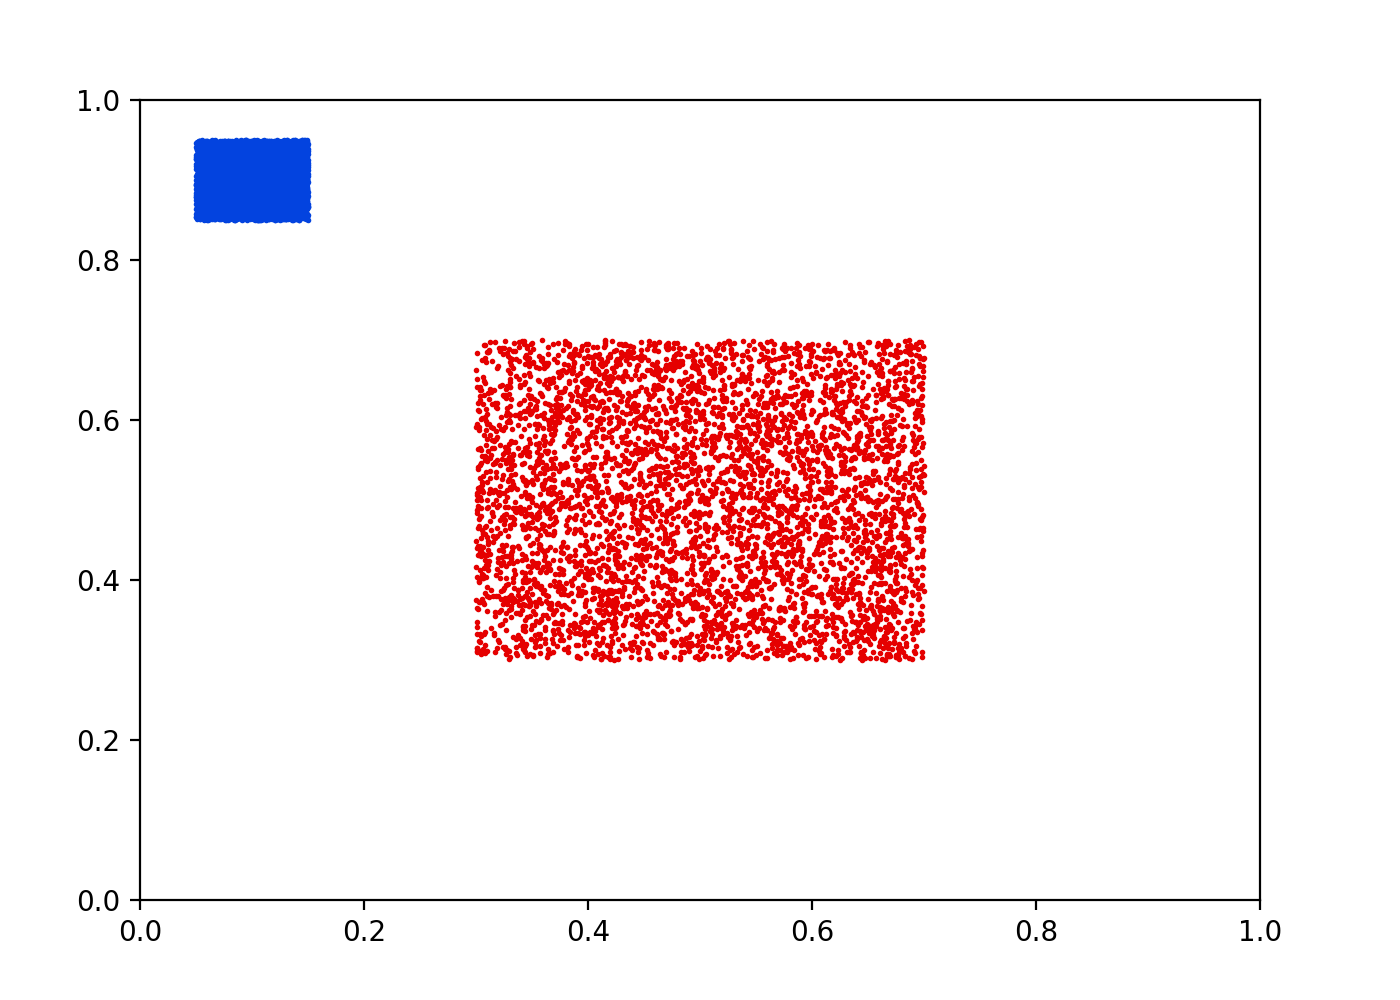

In [3]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

pp=np.array([Cube([0.1,0.9],0.05).random_point() for _ in range(5000)])
sub.scatter(pp[:,0],pp[:,1],c='xkcd:blue',s=1)
pp=np.array([Cube([0.5,0.5],0.2).random_point() for _ in range(5000)])
sub.scatter(pp[:,0],pp[:,1],c='xkcd:red',s=1)





sub.set_xlim(0,1)
sub.set_ylim(0,1) 
plt.show()

In [4]:
class DTree:
    '''
    The DTree class recursively subdivides the space.
    '''
    def __init__(self,boundary,function,number_of_points,max_depth=50):
        '''
        boundary: an instance of Cube. It is the cube that defines this "node" of the tree.
        function: the function whose edges we want to find
        max_depth: number of allowed subdivisions
        number_of_points: draw number_of_points at random in each cube to see if there is an edge. 
        '''
        
        #We deal with cubes, but use the dim when you can. It will be easier to generalize later.
        self.dim=boundary.dim
        
        self.boundary=boundary
        self.function=function
        self.number_of_points=number_of_points
        self.max_depth=max_depth
        
        #List of intances of DTree. This will hold the potential cubes.
        #Each instance of DTree has either 0 or dim**2 children.
        self.children=[0 for i in range(2**self.dim)]  
        self.has_children=False
        
        self.checked=False
        
                        
                        
    def subdivide(self):
        '''Subdivide the cube'''
        self.has_children=True
        new_distance = self.boundary.distance/2. #the distance of all new cubes
        for i in range(2**self.dim):
            new_center = [ self.boundary.signs[i][d]*new_distance + self.boundary.center[d] for d in range(self.dim)]
            child = Cube( new_center , new_distance )
            
            self.children[i]=DTree(child,self.function,self.number_of_points,self.max_depth-1)
        
    
    
    def find_edge(self):
        '''draw a number of random points to see if there is an edge in this cube'''
        if self.max_depth==0:
            return
        if self.has_children:
            for i in self.children:
                i.find_edge()
        else:
            point_1=self.boundary.random_point()
            check_1=self.function(point_1[:-1])>=point_1[-1]
            
            for i in range(self.number_of_points-1):
                point_2=self.boundary.random_point()
                check_2=self.function(point_2[:-1])>point_2[-1]
                if check_2 ^ check_1:
                    self.subdivide()
        
    
    def get_cubes(self):
        '''Get the cubes of the tree and its children  recursively'''
        cubes=[self.boundary]
        if self.has_children:
            for i in self.children:
                for c in i.get_cubes():
                    cubes.append(c)
        return cubes

In [5]:
def find_edges(function,number_of_points=50,max_depth=50):
    '''use this function to find the edges'''
    Qt=DTree(Cube([0.5,0.5],0.5),function,number_of_points,max_depth)
    for i in range(max_depth):
        Qt.find_edge()
    return Qt

In [6]:
def func(x):
#     return np.sin(2*np.pi*x[0])**2
    return np.exp(-50*(x[0]-0.5)**2)*np.sin(5*np.pi*x[0])**2


In [7]:
Qt=find_edges(func,50,7)

<IPython.core.display.Javascript object>


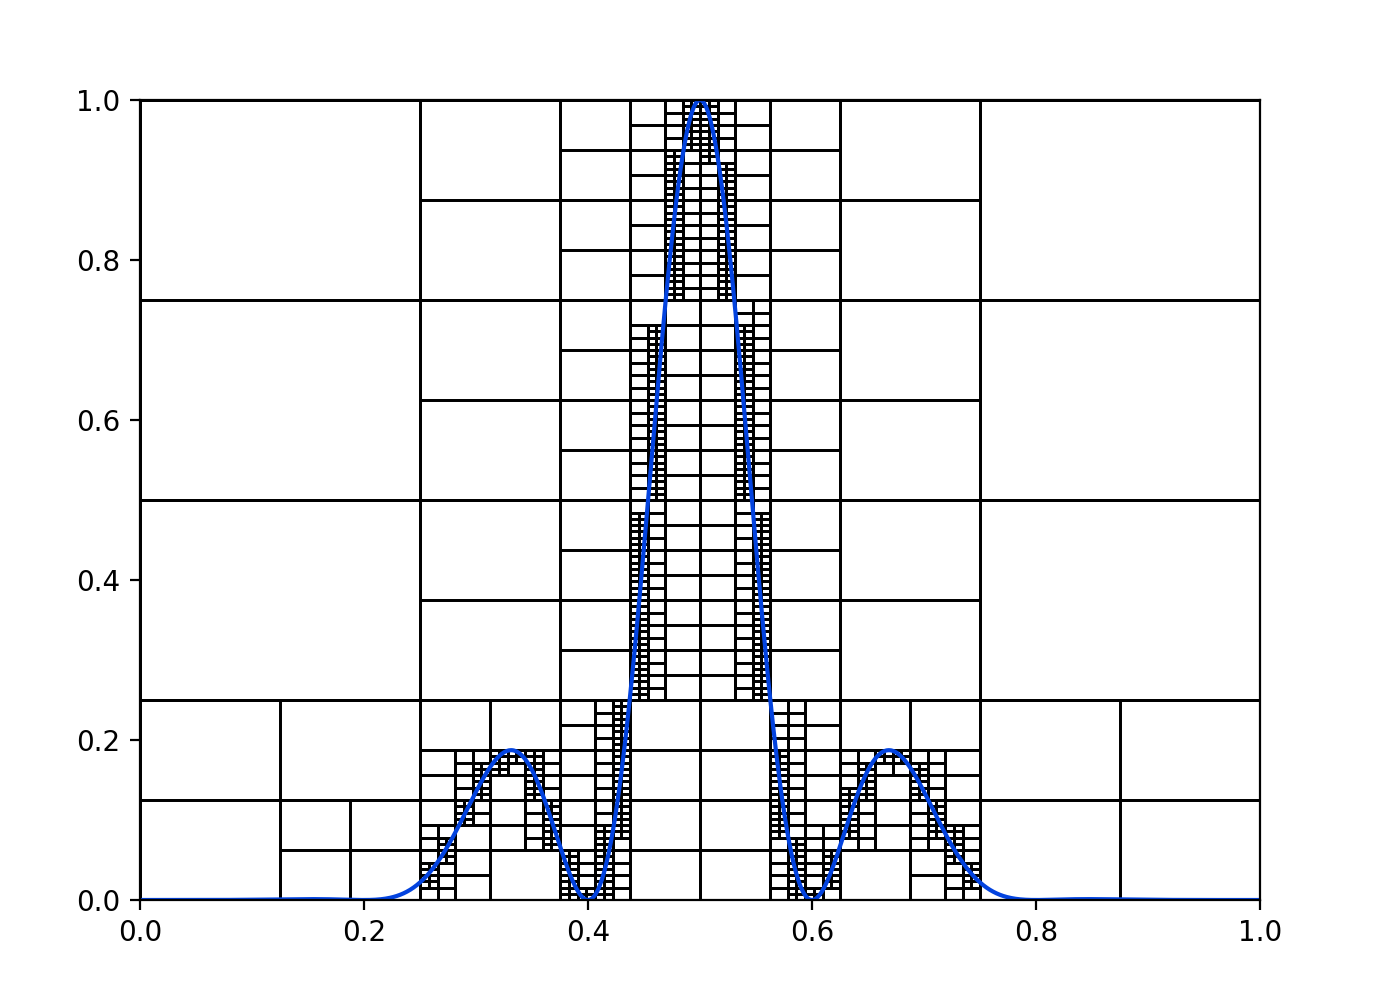

In [8]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

X=np.linspace(0,1,1000)
sub.plot(X,[func([x]) for x in X],c='xkcd:blue')

sq=np.array(Qt.get_cubes())
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[0]-_.distance,_.center[1]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )




sub.set_xlim(0,1)
sub.set_ylim(0,1) 
plt.show()